In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from scipy.ndimage import shift
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Create MATRIX data

In [2]:
rows, cols, sigma = 500, 100, 5.0
coefficients1 = [1,4,-4]
coefficients2 = [3,1,5]
degree1 = 2
degree2 = 2

In [3]:
t_values = np.linspace(-10, 10, cols)
shifted_t_values = np.polyval(coefficients1,t_values)

In [4]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_time_matrix(rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    for col in range(cols):
        for row in range(rows):
            matrix[row, col] = gaussian(row, rows / 2, sigma)
    matrix /= np.max(matrix)
    
    return matrix


In [5]:
Q = create_gaussian_time_matrix(rows, cols, sigma)

In [6]:
def shift_matrix(matrix, shift_vector):
    rows, cols = matrix.shape
    shifted_matrix = np.zeros_like(matrix)
    for col in range(cols):
        shift_val = -shift_vector[col]
        shifted_matrix[:, col] = shift(matrix[:, col], shift_val, mode='nearest')
    return shifted_matrix

In [7]:
Q_with_shift = shift_matrix(Q, shifted_t_values)

In [8]:
def reverse_shift_matrix(shifted_matrix, shift_vector):
    rows, cols = shifted_matrix.shape
    unshifted_matrix = np.zeros_like(shifted_matrix)
    for col in range(cols):
        shift_val = shift_vector[col]
        unshifted_matrix[:, col] = shift(shifted_matrix[:, col], shift_val, mode='nearest')
    return unshifted_matrix

In [9]:
Q_reverse_shift = reverse_shift_matrix(Q_with_shift, shifted_t_values)

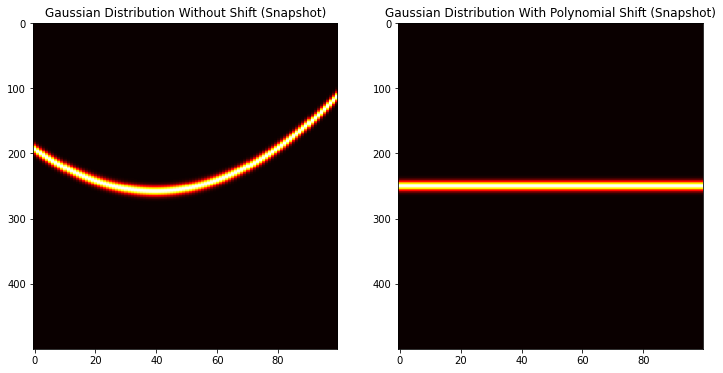

In [10]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(Q_with_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Gaussian Distribution Without Shift (Snapshot)')

# With shift
ax[1].imshow(Q_reverse_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Gaussian Distribution With Polynomial Shift (Snapshot)')

plt.show()

# Define a model

In [11]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, p_init_coeffs, q_init_coeffs=[1], type_NN="polynomial"):
        super(ShiftPredictionModel, self).__init__()
        self.p_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in p_init_coeffs[::-1]]
        )
        self.q_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in q_init_coeffs[::-1]]
        )
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.p_coefficients)])
    
    def forward_rat(self,t):
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.q_coefficients)]) + 1e-6 #avoid dividing by zero
        return self.forward_pol(t)/shift2

    def forward_activ(self, t):
        return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(t)
        return output

## Generate a data for simple polynomial regression

In [12]:
np.random.shuffle(t_values)
np.random.seed(42)

train_size = int(cols * 0.8)
val_size = cols - train_size

x_train = t_values[:train_size]
x_val = t_values[train_size:]
y_train_pol = np.polyval(coefficients1,x_train)
y_val_pol = np.polyval(coefficients1,x_val)

In [13]:
x_train = torch.tensor(x_train, dtype=torch.float64)
x_val = torch.tensor(x_val, dtype=torch.float64)
y_train_pol = torch.tensor(y_train_pol, dtype=torch.float64)
y_val_pol = torch.tensor(y_val_pol, dtype=torch.float64)

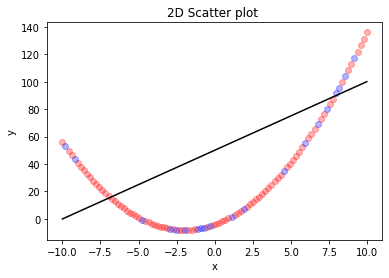

In [14]:
p_coefficients_init = [0,5,50]
t_values = np.linspace(-10, 10, cols)
y_values_pol = np.polyval(p_coefficients_init, t_values)

plt.scatter(x_train, y_train_pol, alpha = 0.3, marker = 'o', color = 'r')
plt.scatter(x_val, y_val_pol, alpha = 0.3, marker = 'o', color = 'b')
plt.plot(t_values,y_values_pol, color = 'k')
plt.title('2D Scatter plot ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Train a model for polynomial function

In [15]:
Q = torch.tensor(Q_with_shift, dtype=torch.float64,requires_grad=True)
t_values_tensor = torch.linspace(-10, 10, cols,dtype=torch.float64)

In [16]:
def tensor_shift(snapshot_matrix, shift_vector):
    rows, cols = snapshot_matrix.shape
    shifted_tensor = snapshot_matrix.clone()
    for i in range(cols):
        shift = int(shift_vector[i].item())
        shifted_tensor[:, i] = torch.roll(snapshot_matrix[:, i], shifts=shift, dims=0)
    return shifted_tensor


In [17]:
class ShiftFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, snapshot_matrix, shift_vector):
        shifted_tensor = tensor_shift(snapshot_matrix, shift_vector)
        ctx.save_for_backward(snapshot_matrix, shift_vector)
        return shifted_tensor

    @staticmethod
    def backward(ctx, grad_output):
        snapshot_matrix, shift_vector = ctx.saved_tensors
        grad_shift_vector = torch.zeros_like(shift_vector)
        for i in range(len(shift_vector)):
            grad_shift_vector[i] = torch.sum(grad_output[:, i])
        return None, grad_shift_vector

In [18]:
def total_variation(shift):
    return torch.sum(torch.abs(shift[..., 1:] - shift[..., :-1]))

In [19]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=True)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag_embed((s > 0).to(dtype))[:s.size(0), :s.size(0)]
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output

In [21]:
model = ShiftPredictionModel(p_init_coeffs=p_coefficients_init,type_NN="polynomial")
model.to(torch.float64)

#optimizer = optim.Adagrad(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.LBFGS(model.parameters(), lr=0.01)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
epochs = 1000
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred_pol = model(t_values_tensor)
    #print(f"y_pred_pol requires grad: {y_pred_pol.requires_grad}")
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients])
    
    TQ = ShiftFunction.apply(Q,y_pred_pol)
    loss = NuclearNormAutograd.apply(TQ)
    #tv_loss=total_variation(y_pred_pol)
    #loss += 0.1 * tv_loss**2
    #print(f"Loss requires grad: {loss.requires_grad}") 
    
    loss.backward()
    
    #print(f"Gradients at Epoch {epoch}:")
    # for name, param in model.named_parameters():
    #     if param.grad is not None:
    #         print(f" - {name}: {param.grad}")

    optimizer.step()
    
    #scheduler.step()
            
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f},Coefficients:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{p_coefficients}')

print(f"Model training complete.")


Epoch [0/1000], Loss: 103.3743,Coefficients:[-4, 4, 1]tensor([50.,  5.,  0.])
Epoch [100/1000], Loss: 107.9866,Coefficients:[-4, 4, 1]tensor([49.8993,  5.0943, -0.1008])
Epoch [200/1000], Loss: 112.5087,Coefficients:[-4, 4, 1]tensor([49.7966,  5.1866, -0.2038])
Epoch [300/1000], Loss: 116.8373,Coefficients:[-4, 4, 1]tensor([49.6922,  5.2817, -0.3086])
Epoch [400/1000], Loss: 121.1768,Coefficients:[-4, 4, 1]tensor([49.5863,  5.3804, -0.4150])
Epoch [500/1000], Loss: 125.4604,Coefficients:[-4, 4, 1]tensor([49.4790,  5.4747, -0.5230])
Epoch [600/1000], Loss: 129.1783,Coefficients:[-4, 4, 1]tensor([49.3707,  5.5649, -0.6322])
Epoch [700/1000], Loss: 133.0074,Coefficients:[-4, 4, 1]tensor([49.2614,  5.6487, -0.7425])
Epoch [800/1000], Loss: 136.8141,Coefficients:[-4, 4, 1]tensor([49.1512,  5.7365, -0.8536])
Epoch [900/1000], Loss: 140.6300,Coefficients:[-4, 4, 1]tensor([49.0402,  5.8214, -0.9655])
Model training complete.


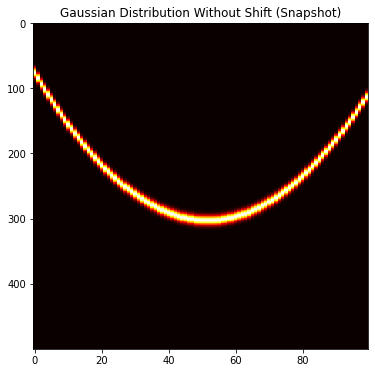

In [22]:
plt.figure(figsize=(6, 6))
plt.imshow(TQ.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
plt.title('Gaussian Distribution Without Shift (Snapshot)')
plt.show()

# TODO

# Rational function

## Create data for rational function regression

In [36]:
np.random.shuffle(t_values)
np.random.seed(42)

train_size = int(cols * 0.8)
val_size = cols - train_size

x_train = t_values[:train_size]
x_val = t_values[train_size:]
y_train_rat = np.polyval(coefficients1,x_train)/np.polyval(coefficients2,x_train)
y_val_rat = np.polyval(coefficients1,x_val)/np.polyval(coefficients2,x_val)

In [37]:
x_train = torch.tensor(x_train, dtype=torch.float64)
x_val = torch.tensor(x_val, dtype=torch.float64)
y_train_rat = torch.tensor(y_train_rat, dtype=torch.float64)
y_val_rat = torch.tensor(y_val_rat, dtype=torch.float64)

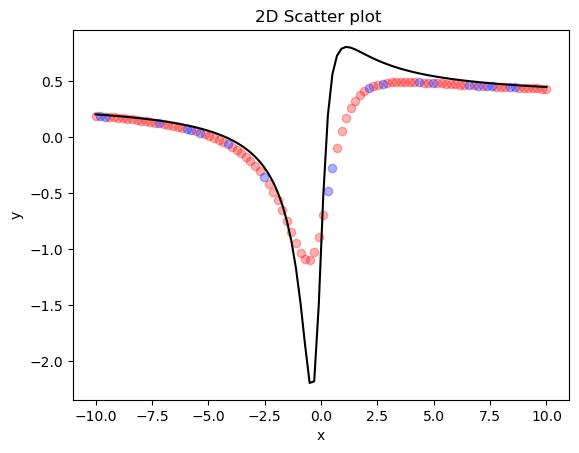

In [38]:
t_values = np.linspace(-10, 10, cols)
p_coefficients_init = [-1,4,1]
q_coefficients_init = [1,1,3]
y_values_rat = np.polyval(np.flip(p_coefficients_init), t_values)/np.polyval(np.flip(q_coefficients_init), t_values)

plt.scatter(x_train, y_train_rat, alpha = 0.3, marker = 'o', color = 'r')
plt.scatter(x_val, y_val_rat, alpha = 0.3, marker = 'o', color = 'b')
plt.plot(t_values,y_values_rat, color = 'k')
plt.title('2D Scatter plot ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [39]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, p_init_coeffs, q_init_coeffs, type_NN):
        super(ShiftPredictionModel, self).__init__()
        self.p_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in p_init_coeffs]
        )
        self.q_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in q_init_coeffs]
        )
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.p_coefficients)])
    
    def forward_rat(self,t):
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.q_coefficients)]) + 1e-6 #avoid dividing by zero
        return self.forward_pol(t)/shift2

    def forward_activ(self, t):
        return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(t)
            #output = self.forward_activ(output)
            
        return output

In [40]:
def custom_loss_l1(y_predicted, y_target, p_coefficients, q_coefficients, x_data):
    # calculate |p(x)-y*q(x)|
    q_x = torch.zeros_like(x_data)
    for i, coeff in enumerate(q_coefficients):
        q_x += coeff * x_data ** i
    return torch.mean(torch.abs(y_predicted - y_target * q_x))

In [41]:
model = ShiftPredictionModel(p_init_coeffs=p_coefficients_init,q_init_coeffs=q_coefficients_init,type_NN="rational") # nn.Linear(40,1)
model.to(torch.float64)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 10000
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred_rat = model(x_train)
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients])
    q_coefficients = torch.tensor([p.item() for p in model.q_coefficients])
    prediction_loss = criterion(y_pred_rat, y_train_rat)
    #tv_loss=total_variation(y_pred_rat)
    loss = prediction_loss #+ 0.5 * tv_loss

    loss.backward()
    optimizer.step()
        
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_val_rat = model(x_val)
        prediction_val_loss = criterion(y_pred_val_rat,y_val_rat) #calculate_loss(y_val,predictions_val).item()
        #tv_test_loss = total_variation(y_pred_val).item()
        val_loss = prediction_val_loss #+ 0.5 * tv_test_loss
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {val_loss:.4f}, Coefficients:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{[coefficients2[::-1][i] for i in range(len(coefficients2))]}{p_coefficients}{q_coefficients}')

print(f"Model training complete.")


Epoch [0/10000], Loss: 0.1491, Test Loss: 0.1262, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-1.,  4.,  1.])tensor([1., 1., 3.])
Epoch [100/10000], Loss: 0.0735, Test Loss: 0.0820, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-1.1554,  3.4938,  0.8414])tensor([1.7591, 1.0515, 2.8472])
Epoch [200/10000], Loss: 0.0315, Test Loss: 0.0321, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-1.8400,  2.8407,  0.6878])tensor([2.4425, 0.8577, 2.1734])
Epoch [300/10000], Loss: 0.0008, Test Loss: 0.0009, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-2.2422,  2.2396,  0.5624])tensor([2.8016, 0.5618, 1.6824])
Epoch [400/10000], Loss: 0.0014, Test Loss: 0.0019, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-2.2447,  2.2471,  0.5633])tensor([2.8052, 0.5629, 1.6802])
Epoch [500/10000], Loss: 0.0006, Test Loss: 0.0006, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-2.2458,  2.2442,  0.5628])tensor([2.8085, 0.5606, 1.6860])
Epoch [600/10000], Loss: 0.0010, Test Loss: 0.0004, Coefficients:[-4, 4, 1][5, 1, 3]tensor([-2.2452,  2.2480,  0.5

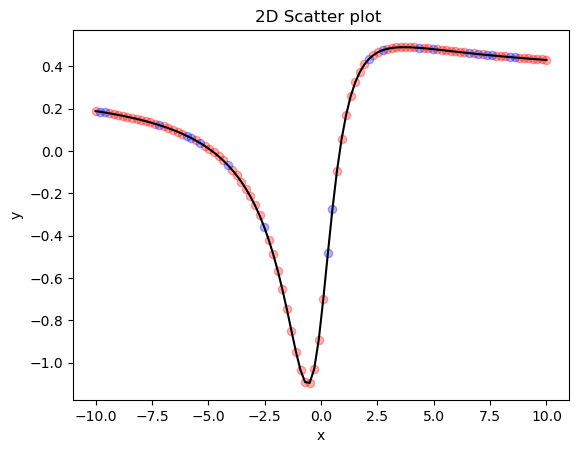

In [42]:
t_values = np.linspace(-10, 10, cols)
y_values_rat = np.polyval(np.flip(p_coefficients.numpy()), t_values)/np.polyval(np.flip(q_coefficients.numpy()), t_values)

plt.scatter(x_train, y_train_rat, alpha = 0.3, marker = 'o', color = 'r')
plt.scatter(x_val, y_val_rat, alpha = 0.3, marker = 'o', color = 'b')
plt.plot(t_values,y_values_rat, color = 'k')
plt.title('2D Scatter plot ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [27]:
print(np.linalg.norm(y_val_rat.detach().numpy() - y_pred_val_rat.detach().numpy()) / np.linalg.norm(y_val_rat.detach().numpy()))

0.002253195
